In [ ]:
 #get all our libraries
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
import random

Initialize States and Q table

In [ ]:
all_acc=[] #here we keep the entire history of state sequences and corresponding accuracies


In [ ]:
#we initialize our sequence space so that each layer type may appear at each layer number
#its a dictionary so that each tuple can be later indexed in our Q-table
states = {(0, 'i', 1):0,
          (1, 'c', 1):1,
          (1, 'p', 1):2,
          (1, 'd', 0):3,
          (1, 't', 0):4,
          (2, 'c', 1):5,
          (2, 'p', 1):6,
          (2, 'd', 0):7,
          (2, 't', 0):8,
          (3, 'c', 1):9,
          (3, 'p', 1):10,
          (3, 'd', 0):11,
          (3, 't', 0):12,
          (4, 'c', 1):13,
          (4, 'p', 1):14,
          (4, 'd', 0):15,
          (4, 't', 0):16,
          (5, 'c', 1):17,
          (5, 'p', 1):18,
          (5, 'd', 0):19,
          (5, 't', 0):20,
          (6, 't', 0):21
          }
#we initialize all the layer types that we can choose as our actions. They are also indexed for use in Q-table.
#note that input layer type'i' is not included
actions = {'c':0, 'p':1, 'd':2, 't':3}

alpha = 0.01 #Q-learning rate

num_states = len(states) #creates an integer that is the length of all possible states, that we use to initialize the Q-table
num_actions = len(actions) #creates an integer that is the length of all possible actions, that we use to initialize the Q-table

Q_table = np.zeros((num_states, num_actions)) #initialize Q-table
print(Q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [ ]:
#we initialize the Q table to reflect the permissible actions
#non-permissible actions will be zero in the Q-table below
for i in range(len(states)-1):
  if (list (states.keys())[i][2]==0):
    Q_table[i][2]=.5
    Q_table[i][3]=.5
  else:
    Q_table[i][0]=.5
    Q_table[i][1]=.5
    Q_table[i][2]=.5
    Q_table[i][3]=.5
print (Q_table)

[[0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.  0.  0.5 0.5]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.  0.  0.5 0.5]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.  0.  0.5 0.5]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.  0.  0.5 0.5]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.  0.  0.5 0.5]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  0. ]]


Import Data Set

In [ ]:
batch_size = 128
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)
x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)









x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
#this function takes in the previous state and action it returns the new state chosen
#it uses the indicators to ensure that once the network has reached a dense or terminal layer, -
#it cannot return to a convolutional or maxpooling layer state
def transition(state, action):
  layer_num, layer_type, indicator = state
  layer_num += 1
  if action in ['d', 't']:
    indicator = 0
  else:
    indicator = 1
  new_state = (layer_num, action, indicator)
  return new_state

#this function returns the permissible actions at a given state
#the indicator state variable indicates whether it is possible for the next layer to be convolutional or maxpooling
#1 indicates that all layers types are still permissibile
#0 indicates that only dense layers or the termination layer are allowed
#the first if statements ensures that there is a max number of 8 layers allowed
def permissible_actions(state):
  layer_num, layer_type, indicator = state
  if layer_num==5:
    actions=['t']
  else:
    if indicator==0:
      actions = ['d', 't']
    else:
      actions = ['c', 'p', 'd', 't']

  return actions

#this function implements a part of the Q-learning algorithm that samples a new network architecture based on the current Q-table
#it starts from an initial state and iteratively selects actions until a terminal action is chosen, forming a path through the state-action space.
#the selection of actions is based on an epsilon-greedy strategy, which balances exploration (random action selection) -
#-and exploitation (choosing the action with the highest expected reward, based on the Q-table)
def sample_new_network(epsilon, Q_table):
  state_seqn = [(0, 'i',1)]
  action_seqn = []

  while (action_seqn==[] or action_seqn[-1]!='t'):
    beta = random.random()
    if beta > epsilon:
      state = states.get(state_seqn[-1])
      permissible_indices = []

      for i in permissible_actions(state_seqn[-1]):
        permissible_indices.append(actions.get(i))

      q_values = list(Q_table[state])

      permissible_q_values = [q_values for i in permissible_indices]
      max_action = max(permissible_q_values)
      max_action_index = permissible_q_values.index(max_action)+(len(q_values)-len(permissible_indices))
      u = list(actions.keys())[max_action_index]

      s = transition(state_seqn[-1], u)
    else:
      u = random.choice(permissible_actions(state_seqn[-1]))
      s = transition(state_seqn[-1], u)
    action_seqn.append(u)
    if u!='t':
      state_seqn.append(s)

  return state_seqn, action_seqn

#this function updates Q-values based on the received accuracy of the sampled network
#it iterate backwards through the state-action sequence to update the Q-values for all state-action pairs-
#-which allows the algorithm to propagate the accuracy information back to the initial states.
def update_q_values(Q, state_seqn, action_seqn, accuracy):
    """Update Q values based on the received accuracy (reward) for the sampled network."""
    Q[states.get(state_seqn[-1])][actions.get(action_seqn[-1])] = (1 - alpha) * Q[states.get(state_seqn[-1])][actions.get(action_seqn[-1])] + alpha * accuracy
    for i in range(len(state_seqn) - 2, -1, -1):
        best_future_q = max(Q[states.get(state_seqn[i])][actions.get(future_action)] for future_action in permissible_actions(state_seqn[i+1]))
        Q[states.get(state_seqn[i])][actions.get(action_seqn[i])] = (1 - alpha) * Q[states.get(state_seqn[i])][actions.get(action_seqn[i])] + alpha * best_future_q




In [ ]:
#this function creates the actual convolution network by adding the layers given by the sequence of chosen states by the agent
#the first double-if statement is in place for time efficiency, so that if a state sequence has already appeared in the-
#-model we just return the accuracy of the episode instead of rerunning that CNN
#this function is where we choose what exact layers we want the agent to choose from
#finally, it compiles the given CNN, and compares the output to the true categories so as to obtain an accuracy score
def train(state_seqn):
  if len(all_acc)>0:
    first_elements = [x[0] for x in all_acc]
    if state_seqn in first_elements:
      return all_acc[first_elements.index(state_seqn)][1]

  model = Sequential()
  model.add(keras.Input(shape=(28,28,1)))
  if len(state_seqn)==1:
    model.add(Flatten())
    model.add(Dense(10, activation='Softmax', input_shape=(28, 28, 1)))
  else:
      counter =0

      for state in state_seqn[1:]:
        if state[1] == 'c':
          model.add(Conv2D(32, kernel_size= (2, 2), padding='same',activation='relu'))
        elif state[1] == 'p':
          model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
        elif state[1] == 'd':
          model.add(Flatten())
          model.add(Dense(128, activation='relu'))
        if (counter%2 == 0):
          model.add(Dropout(0.2))
        counter+=1
      model.add(Flatten())
      model.add(Dense(10, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(learning_rate = 1e-2),
              metrics=['accuracy'])


  model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(x_test, y_test))
  score = model.evaluate(x_test, y_test, verbose=0)

  return score[1]

In [ ]:
#this is the main function of our Q-learning model that uses all of the functions created above
#the first for loop runs the episodes where for each a new neural network architecture is sampled-
#deciding the architecture based on the current Q-table and the exploration rate
#the second for loop implements the use of a replay memory for updating Q-values multiple times-
#-within each episode which allows for improved stability and efficiency of reinforcement learning algorithms

def meta_qnn_algorithm(epsilon, m=10, k=5):
    """MetaQNN main algorithm."""
    SS_acc_list=[()]
    replay_memory = []


    for episode in range(1, m + 1):
        state_seqn, action_seqn = sample_new_network(epsilon, Q_table)
        accuracy = train(state_seqn)
        tup=(state_seqn,accuracy)
        SS_acc_list=[]
        SS_acc_list.append(tup)
        replay_memory.append((state_seqn, action_seqn, accuracy))
        all_acc.append(tup)

        for memory in range(1, k+1):
            Ssample, Usample, ACCsample = random.choice(replay_memory)
            update_q_values(Q_table, Ssample, Usample, ACCsample)





In [ ]:
#finally we run the meta_qnn_algorithm multiple times with various epsilon values
#we start with a large number at epsilon=1 to give it appropriate time to explore-
#-before it eventually chooses more 'greedy' options
#we decrement epsilon by .1 making the agent more 'greedy' until it reaches 0.1-
#-where it should converge to an optimal CNN

for i in range(50):
  meta_qnn_algorithm(1)
for i in range(30):
  meta_qnn_algorithm(0.9)
for i in range(10):
  meta_qnn_algorithm(0.8)
for i in range(8):
  meta_qnn_algorithm(0.7)
for i in range(8):
  meta_qnn_algorithm(0.6)
for i in range(8):
  meta_qnn_algorithm(0.5)
for i in range(8):
  meta_qnn_algorithm(0.4)
for i in range(8):
  meta_qnn_algorithm(0.3)
for i in range(10):
  meta_qnn_algorithm(0.2)
for i in range(20):
  meta_qnn_algorithm(0.1)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


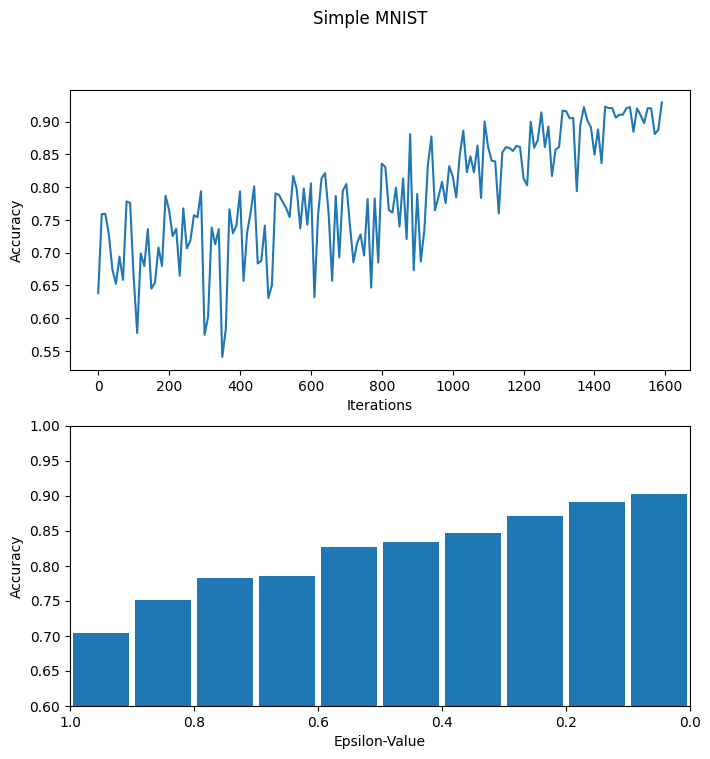

+----------+----------+----------+----------+
| 0.6269   | 0.626898 | 0.626897 | 0.6269   |
+----------+----------+----------+----------+
| 0.931075 | 0.924094 | 0.926186 | 0.931076 |
+----------+----------+----------+----------+
| 0.5      | 0.5      | 0.5      | 0.338505 |
+----------+----------+----------+----------+
| 0        | 0        | 0.810608 | 0.811586 |
+----------+----------+----------+----------+
| 0        | 0        | 0.5      | 0.5      |
+----------+----------+----------+----------+
| 0.90754  | 0.873601 | 0.85229  | 0.90887  |
+----------+----------+----------+----------+
| 0.561457 | 0.515817 | 0.513054 | 0.570668 |
+----------+----------+----------+----------+
| 0        | 0        | 0.87274  | 0.878006 |
+----------+----------+----------+----------+
| 0        | 0        | 0.5      | 0.5      |
+----------+----------+----------+----------+
| 0.828617 | 0.722768 | 0.745279 | 0.828703 |
+----------+----------+----------+----------+
| 0.627105 | 0.529099 | 0.540785 |

In [ ]:
#here we create our graphs track accuracy across iterations-
#-and then accuracy compared to the values of epsilon
import matplotlib.pyplot as plt
from tabulate import tabulate

acc = []
for i in all_acc:
  acc.append(i[1])


mid_resolution = np.zeros(160)

for i in range (160):
  for j in range(10):
    mid_resolution[i]+= acc[10*i+j]


average = np.zeros(10)

for i in range(0,500):
  average[0]+=acc[i]/500

for i in range(500,800):
  average[1]+=acc[i]/300

for i in range(800,900):
  average[2]+=acc[i]/100

for i in range(900,980):
  average[3]+=acc[i]/80

for i in range(980,1060):
  average[4]+=acc[i]/80

for i in range(1060,1140):
  average[5]+=acc[i]/80

for i in range(1140,1220):
  average[6]+=acc[i]/80

for i in range(1220,1300):
  average[7]+=acc[i]/80

for i in range(1300,1400):
  average[8]+=acc[i]/100

for i in range(1400,1600):
  average[9]+=acc[i]/200






fig, axs = plt.subplots(2, figsize=(8, 8))

axs[0].plot(10*np.arange(0,len(mid_resolution)) , 0.1*mid_resolution)
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Iterations')


axs[1].bar(np.linspace(0.95,0.05,10), average,width = 0.09)
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epsilon-Value')
axs[1].set_ylim(0.6,1)
axs[1].set_xlim(1,0)

fig.suptitle('Simple MNIST')
print('')

plt.show()


print(tabulate(Q_table, tablefmt='grid'))



print(all_acc[-1])
